# 1. Simulate splitting and merging objects over time

In [9]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
# import uuid
import json
# import stat


## Custom functions

In [27]:
@dataclass
class SimObject:
    """Represents a simulated object with tracking capabilities"""
    id: str
    x: float
    y: float
    radius: float
    birth_frame: int
    death_frame: Optional[int] = None
    parent_ids: List[str] = field(default_factory=list)
    child_ids: List[str] = field(default_factory=list)
    lineage_id: str = None
    
    def __post_init__(self):
        if self.lineage_id is None:
            self.lineage_id = self.id

@dataclass
class Event:
    """Records split/merge events"""
    frame: int
    event_type: str  # 'split' or 'merge'
    parent_ids: List[str]
    child_ids: List[str]
    location: Tuple[float, float]

class SplitMergeSimulator:
    """Simulates objects that can split and merge with lineage tracking"""
    
    def __init__(self, width=100, height=100, max_frames=200, random_seed=None):
        self.width = width
        self.height = height
        self.max_frames = max_frames
        self.random_seed = random_seed
        self.objects = {}  # Current active objects
        self.all_objects = {}  # All objects ever created
        self.events = []
        self.frames = []  # Store frame data
        self.current_frame = 0
        self.next_object_id = 1
        
        # Set random seed if provided
        if random_seed is not None:
            np.random.seed(random_seed)
        
    def generate_object_id(self) -> str:
        """Generate unique object ID"""
        obj_id = f"obj_{self.next_object_id:03d}"
        self.next_object_id += 1
        return obj_id
    
    def create_object(self, x, y, radius=3.0, parent_ids=None, lineage_id=None):
        """Create a new object"""
        obj_id = self.generate_object_id()
        
        # Determine lineage ID
        if lineage_id is None:
            if parent_ids and len(parent_ids) == 1:
                # Split case - inherit lineage from parent
                lineage_id = self.all_objects[parent_ids[0]].lineage_id
            elif parent_ids and len(parent_ids) > 1:
                # Merge case - inherit from largest parent
                parent_sizes = [(pid, self.all_objects[pid].radius) for pid in parent_ids]
                largest_parent = max(parent_sizes, key=lambda x: x[1])[0]
                lineage_id = self.all_objects[largest_parent].lineage_id
            else:
                # New lineage
                lineage_id = f"lineage_{obj_id}"
        
        obj = SimObject(
            id=obj_id,
            x=x, y=y, 
            radius=radius,
            birth_frame=self.current_frame,
            parent_ids=parent_ids or [],
            lineage_id=lineage_id
        )
        
        # Update parent-child relationships
        if parent_ids:
            for parent_id in parent_ids:
                if parent_id in self.all_objects:
                    self.all_objects[parent_id].child_ids.append(obj_id)
        
        self.objects[obj_id] = obj
        self.all_objects[obj_id] = obj
        return obj_id
    
    def remove_object(self, obj_id):
        """Remove object from simulation"""
        if obj_id in self.objects:
            self.all_objects[obj_id].death_frame = self.current_frame
            del self.objects[obj_id]
    
    def split_object(self, obj_id, split_distance=8.0):
        """Split an object into two children"""
        if obj_id not in self.objects:
            return []
        
        parent = self.objects[obj_id]
        
        # Create two child objects
        angle = np.random.uniform(0, 2*np.pi)
        dx = split_distance * np.cos(angle) / 2
        dy = split_distance * np.sin(angle) / 2
        
        child1_id = self.create_object(
            x=parent.x + dx,
            y=parent.y + dy,
            radius=parent.radius * 0.8,  # Slightly smaller
            parent_ids=[obj_id],
            lineage_id=parent.lineage_id
        )
        
        child2_id = self.create_object(
            x=parent.x - dx,
            y=parent.y - dy,
            radius=parent.radius * 0.8,
            parent_ids=[obj_id],
            lineage_id=parent.lineage_id
        )
        
        # Record event
        event = Event(
            frame=self.current_frame,
            event_type='split',
            parent_ids=[obj_id],
            child_ids=[child1_id, child2_id],
            location=(parent.x, parent.y)
        )
        self.events.append(event)
        
        # Remove parent
        self.remove_object(obj_id)
        
        return [child1_id, child2_id]
    
    def merge_objects(self, obj_ids, merge_radius_factor=1.2):
        """Merge multiple objects into one"""
        if len(obj_ids) < 2:
            return None
        
        # Calculate merged position (center of mass)
        total_mass = sum(self.objects[oid].radius**2 for oid in obj_ids if oid in self.objects)
        if total_mass == 0:
            return None
            
        merge_x = sum(self.objects[oid].x * self.objects[oid].radius**2 
                     for oid in obj_ids if oid in self.objects) / total_mass
        merge_y = sum(self.objects[oid].y * self.objects[oid].radius**2 
                     for oid in obj_ids if oid in self.objects) / total_mass
        
        # New radius based on area conservation
        total_area = sum(np.pi * self.objects[oid].radius**2 for oid in obj_ids if oid in self.objects)
        new_radius = np.sqrt(total_area / np.pi) * merge_radius_factor
        
        # Create merged object
        merged_id = self.create_object(
            x=merge_x, y=merge_y,
            radius=new_radius,
            parent_ids=obj_ids
        )
        
        # Record event
        event = Event(
            frame=self.current_frame,
            event_type='merge',
            parent_ids=obj_ids.copy(),
            child_ids=[merged_id],
            location=(merge_x, merge_y)
        )
        self.events.append(event)
        
        # Remove parent objects
        for obj_id in obj_ids:
            self.remove_object(obj_id)
        
        return merged_id
    
    def find_nearby_objects(self, obj_id, max_distance=10.0):
        """Find objects within merging distance"""
        if obj_id not in self.objects:
            return []
        
        target = self.objects[obj_id]
        nearby = []
        
        for other_id, other_obj in self.objects.items():
            if other_id != obj_id:
                distance = np.sqrt((target.x - other_obj.x)**2 + (target.y - other_obj.y)**2)
                if distance <= max_distance:
                    nearby.append(other_id)
        
        return nearby
    
    def random_walk_objects(self, step_size=1.0):
        """Apply random walk to all objects"""
        for obj in self.objects.values():
            dx = np.random.normal(0, step_size)
            dy = np.random.normal(0, step_size)
            
            # Keep within bounds
            obj.x = np.clip(obj.x + dx, obj.radius, self.width - obj.radius)
            obj.y = np.clip(obj.y + dy, obj.radius, self.height - obj.radius)
    
    def step(self, split_prob=0.02, merge_prob=0.01):
        """Advance simulation by one frame"""
        # Store current frame state
        frame_data = {
            'frame': self.current_frame,
            'objects': {oid: (obj.x, obj.y, obj.radius, obj.lineage_id) 
                       for oid, obj in self.objects.items()}
        }
        self.frames.append(frame_data)
        
        # Random walk
        self.random_walk_objects()
        
        # Random splits
        objects_to_split = []
        for obj_id in list(self.objects.keys()):
            if np.random.random() < split_prob and len(self.objects) < 20:  # Limit population
                objects_to_split.append(obj_id)
        
        for obj_id in objects_to_split:
            self.split_object(obj_id)
        
        # Random merges
        checked_objects = set()
        for obj_id in list(self.objects.keys()):
            if obj_id in checked_objects or obj_id not in self.objects:
                continue
                
            if np.random.random() < merge_prob:
                nearby = self.find_nearby_objects(obj_id, max_distance=8.0)
                if nearby:
                    # Merge with one random nearby object
                    merge_partner = np.random.choice(nearby)
                    if merge_partner not in checked_objects:
                        self.merge_objects([obj_id, merge_partner])
                        checked_objects.update([obj_id, merge_partner])
        
        self.current_frame += 1
    
    def run_simulation(self, n_initial_objects=5, split_prob=0.02, merge_prob=0.01, random_seed=None):
        """Run complete simulation"""
        # Set random seed for this run (overrides constructor seed if provided)
        if random_seed is not None:
            self.random_seed = random_seed
            np.random.seed(random_seed)
        elif self.random_seed is not None:
            # Re-set the seed to ensure reproducibility even if called multiple times
            np.random.seed(self.random_seed)
        
        # Store simulation parameters for reference
        self.simulation_params = {
            'n_initial_objects': n_initial_objects,
            'split_prob': split_prob,
            'merge_prob': merge_prob,
            'random_seed': self.random_seed
        }
        
        # Initialize with random objects
        for _ in range(n_initial_objects):
            x = np.random.uniform(20, self.width - 20)
            y = np.random.uniform(20, self.height - 20)
            self.create_object(x, y, radius=np.random.uniform(3, 6))
        
        # Run simulation
        for frame in range(self.max_frames):
            self.step(split_prob, merge_prob)
            
            # Stop if no objects remain
            if not self.objects:
                break
    
    def get_ground_truth_events(self):
        """Return ground truth events as DataFrame"""
        events_data = []
        for event in self.events:
            events_data.append({
                'frame': event.frame,
                'event_type': event.event_type,
                'parent_ids': ','.join(event.parent_ids),
                'child_ids': ','.join(event.child_ids),
                'location_x': event.location[0],
                'location_y': event.location[1]
            })
        return pd.DataFrame(events_data)
    
    def get_lineage_tree(self):
        """Return lineage information as DataFrame"""
        lineage_data = []
        for obj in self.all_objects.values():
            lineage_data.append({
                'object_id': obj.id,
                'lineage_id': obj.lineage_id,
                'birth_frame': obj.birth_frame,
                'death_frame': obj.death_frame,
                'parent_ids': ','.join(obj.parent_ids),
                'child_ids': ','.join(obj.child_ids),
                'final_x': obj.x,
                'final_y': obj.y,
                'radius': obj.radius
            })
        return pd.DataFrame(lineage_data)
    
    def create_binary_masks(self):
        """Generate binary masks for each frame (for ARCOS.px input)"""
        masks = []
        for frame_data in self.frames:
            mask = np.zeros((self.height, self.width), dtype=np.uint8)
            
            for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
                # Create circular mask
                yy, xx = np.ogrid[:self.height, :self.width]
                circle_mask = (xx - x)**2 + (yy - y)**2 <= radius**2
                mask[circle_mask] = 1
            
            masks.append(mask)
        
        return np.array(masks)
    
    def create_object_masks(self):
        """Generate object masks where pixel values correspond to individual object IDs"""
        # First, collect all unique object IDs across all frames
        all_objects = set()
        for frame_data in self.frames:
            for obj_id in frame_data['objects'].keys():
                all_objects.add(obj_id)
        
        # Create mapping from object ID to integer (starting from 1, 0 = background)
        object_to_int = {}
        for i, obj_id in enumerate(sorted(all_objects), 1):
            object_to_int[obj_id] = i
        
        # Generate masks
        masks = []
        for frame_data in self.frames:
            mask = np.zeros((self.height, self.width), dtype=np.uint16)  # uint16 for more objects
            
            for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
                # Create circular mask with object ID value
                yy, xx = np.ogrid[:self.height, :self.width]
                circle_mask = (xx - x)**2 + (yy - y)**2 <= radius**2
                mask[circle_mask] = object_to_int[obj_id]
            
            masks.append(mask)
        
        return np.array(masks), object_to_int
    
    def create_lineage_masks(self):
        """Generate lineage masks where pixel values correspond to lineage IDs"""
        # First, collect all unique lineage IDs
        all_lineages = set()
        for frame_data in self.frames:
            for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
                all_lineages.add(lineage_id)
        
        # Create mapping from lineage ID to integer (starting from 1, 0 = background)
        lineage_to_int = {}
        for i, lineage_id in enumerate(sorted(all_lineages), 1):
            lineage_to_int[lineage_id] = i
        
        # Generate masks
        masks = []
        for frame_data in self.frames:
            mask = np.zeros((self.height, self.width), dtype=np.uint16)  # uint16 for more lineages
            
            for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
                # Create circular mask with lineage value
                yy, xx = np.ogrid[:self.height, :self.width]
                circle_mask = (xx - x)**2 + (yy - y)**2 <= radius**2
                mask[circle_mask] = lineage_to_int[lineage_id]
            
            masks.append(mask)
        
        return np.array(masks), lineage_to_int
    
    def visualize_frame(self, frame_num, ax=None, show_ids=True):
        """Visualize a specific frame"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        if frame_num < len(self.frames):
            frame_data = self.frames[frame_num]
            
            ax.set_xlim(0, self.width)
            ax.set_ylim(0, self.height)
            ax.set_aspect('equal')
            ax.set_facecolor('black')  # Black background for better contrast
            
            # Color map for lineages
            lineage_colors = {}
            colors = plt.cm.tab10(np.linspace(0, 1, 10))
            
            for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
                if lineage_id not in lineage_colors:
                    lineage_colors[lineage_id] = colors[len(lineage_colors) % len(colors)]
                
                circle = Circle((x, y), radius, 
                              color=lineage_colors[lineage_id], 
                              alpha=0.8, 
                              edgecolor='white',
                              linewidth=1)
                ax.add_patch(circle)
                
                if show_ids:
                    ax.text(x, y, obj_id.split('_')[1], ha='center', va='center', 
                           fontsize=8, color='white', weight='bold')
            
            ax.set_title(f'Frame {frame_num}', color='white')
            ax.tick_params(colors='white')
        
        return ax
    
    def visualize_object_mask(self, frame_num, ax=None):
        """Visualize object mask for a specific frame with color coding"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        if frame_num < len(self.frames):
            object_masks, object_mapping = self.create_object_masks()
            mask = object_masks[frame_num]
            
            # Create inverse mapping for labels
            int_to_object = {v: k for k, v in object_mapping.items()}
            
            # Display with colormap
            im = ax.imshow(mask, cmap='viridis', vmin=0, vmax=max(object_mapping.values()))
            ax.set_title(f'Object Mask - Frame {frame_num}')
            
            # Add colorbar with object labels
            unique_values = np.unique(mask)
            unique_values = unique_values[unique_values > 0]  # Exclude background
            
            if len(unique_values) > 0:
                cbar = plt.colorbar(im, ax=ax, ticks=unique_values)
                cbar.set_label('Object ID')
                # Set tick labels to actual object names (shortened)
                tick_labels = [int_to_object.get(val, f'ID_{val}').replace('obj_', '') 
                             for val in unique_values]
                cbar.set_ticklabels(tick_labels)
        
        return ax
    
    def visualize_lineage_mask(self, frame_num, ax=None):
        """Visualize lineage mask for a specific frame with color coding"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        if frame_num < len(self.frames):
            lineage_masks, lineage_mapping = self.create_lineage_masks()
            mask = lineage_masks[frame_num]
            
            # Create inverse mapping for labels
            int_to_lineage = {v: k for k, v in lineage_mapping.items()}
            
            # Display with colormap
            im = ax.imshow(mask, cmap='tab10', vmin=0, vmax=max(lineage_mapping.values()))
            ax.set_title(f'Lineage Mask - Frame {frame_num}')
            
            # Add colorbar with lineage labels
            unique_values = np.unique(mask)
            unique_values = unique_values[unique_values > 0]  # Exclude background
            
            if len(unique_values) > 0:
                cbar = plt.colorbar(im, ax=ax, ticks=unique_values)
                cbar.set_label('Lineage ID')
                # Set tick labels to actual lineage names (shortened)
                tick_labels = [int_to_lineage.get(val, f'ID_{val}').replace('lineage_obj_', '') 
                             for val in unique_values]
                cbar.set_ticklabels(tick_labels)
        
        return ax
    
    def save_simulation_data(self, output_dir='simulation_output', save_png=True, save_npy=True, save_csv=True, save_json=True, save_summary_plots=True, save_viz_frames=True):
        """Save all simulation data to specified directory"""
        try:
            from PIL import Image
        except ImportError:
            print("Warning: PIL not available. Install with 'pip install Pillow'")
            print("Will save numpy arrays only.")
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Saving simulation data to: {output_dir}")
        
        # 1. Save binary masks as images and numpy array
        binary_masks = self.create_binary_masks()
        lineage_masks, lineage_mapping = self.create_lineage_masks()
        object_masks, object_mapping = self.create_object_masks()
        
        # Save binary masks
        if save_npy:
            np.save(os.path.join(output_dir, 'binary_masks.npy'), binary_masks)
            print(f"✓ Saved {len(binary_masks)} binary masks (numpy array)")
            
            # Save object masks and mapping
            np.save(os.path.join(output_dir, 'object_masks.npy'), object_masks)            
            print(f"✓ Saved {len(object_masks)} object masks with {len(object_mapping)} objects")
    
            # Save lineage masks and mapping
            np.save(os.path.join(output_dir, 'lineage_masks.npy'), lineage_masks)            
            print(f"✓ Saved {len(lineage_masks)} lineage masks with {len(lineage_mapping)} lineages")
            
        if save_json:    
            # Save object mapping as JSON
            with open(os.path.join(output_dir, 'object_mapping.json'), 'w') as f:
                json.dump(object_mapping, f, indent=2)
                
            # Save lineage mapping as JSON
            with open(os.path.join(output_dir, 'lineage_mapping.json'), 'w') as f:
                json.dump(lineage_mapping, f, indent=2)

        # Save individual mask images as PNGs (if PIL available)
        if save_png and 'PIL' in globals():        
            try:
                from PIL import Image
                mask_dir = os.path.join(output_dir, 'binary_masks')
                os.makedirs(mask_dir, exist_ok=True)
                
                for i, mask in enumerate(binary_masks):
                    # Convert to 8-bit image (0 or 255)
                    mask_img = (mask * 255).astype(np.uint8)
                    Image.fromarray(mask_img, mode='L').save(
                        os.path.join(mask_dir, f'mask_{i:04d}.png'))
                
                print(f"✓ Saved {len(self.frames)} mask PNG files")


                # Save object mask images (normalized for visualization)
                object_dir = os.path.join(output_dir, 'object_masks')
                os.makedirs(object_dir, exist_ok=True)

                # Normalize object values to 0-255 range for visualization
                max_object = np.max(object_masks) if len(object_masks) > 0 else 1
                for i, mask in enumerate(object_masks):
                    # Scale object values to full 8-bit range
                    mask_normalized = (mask * 255 / max_object).astype(np.uint8)
                    Image.fromarray(mask_normalized, mode='L').save(
                        os.path.join(object_dir, f'object_{i:04d}.png'))

                print(f"✓ Saved {len(self.frames)} object mask PNG files")
                
                
                # Save lineage mask images (normalized for visualization)
                lineage_dir = os.path.join(output_dir, 'lineage_masks')
                os.makedirs(lineage_dir, exist_ok=True)
                
                # Normalize lineage values to 0-255 range for visualization
                max_lineage = np.max(lineage_masks) if len(lineage_masks) > 0 else 1
                for i, mask in enumerate(lineage_masks):
                    # Scale lineage values to full 8-bit range
                    mask_normalized = (mask * 255 / max_lineage).astype(np.uint8)
                    Image.fromarray(mask_normalized, mode='L').save(
                        os.path.join(lineage_dir, f'lineage_{i:04d}.png'))
                    
                print(f"✓ Saved {len(self.frames)} lineage mask PNG files")
                
            except ImportError:
                print("PIL not available - skipping individual mask image export")
        
        # 2. Save visualization frames
        if save_viz_frames:
            viz_dir = os.path.join(output_dir, 'visualizations')
            os.makedirs(viz_dir, exist_ok=True)
            
            # Generate consistent lineage colors
            all_lineages = set()
            for frame_data in self.frames:
                for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
                    all_lineages.add(lineage_id)
            
            lineage_colors = {}
            colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(all_lineages))))
            for i, lineage_id in enumerate(sorted(all_lineages)):
                lineage_colors[lineage_id] = colors[i % len(colors)]
            
            for frame_num in range(len(self.frames)):
                self.plot_viz_frame(viz_dir, lineage_colors, frame_num)
                
            print(f"✓ Saved {len(self.frames)} visualization frames")

        
        # 3. Save ground truth data
        if save_csv:
            events_df = self.get_ground_truth_events()
            events_df.to_csv(os.path.join(output_dir, 'ground_truth_events.csv'), index=False)
            print(f"✓ Saved ground truth data ({len(events_df)} events)")

            lineage_df = self.get_lineage_tree()
            lineage_df.to_csv(os.path.join(output_dir, 'lineage_tree.csv'), index=False)
            print(f"✓ Saved lineage tree data ({len(lineage_df)} lineages)")
        
        # 4. Save frame-by-frame object data
        if save_csv:
            frame_data_list = []
            for frame_num, frame_data in enumerate(self.frames):
                for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
                    frame_data_list.append({
                        'frame': frame_num,
                        'object_id': obj_id,
                        'x': x,
                        'y': y,
                        'radius': radius,
                        'lineage_id': lineage_id
                    })
            
            frame_df = pd.DataFrame(frame_data_list)
            frame_df.to_csv(os.path.join(output_dir, 'frame_data.csv'), index=False)
            print(f"✓ Saved frame-by-frame object data ({len(frame_df)} items)")

        # 5. Save simulation parameters
        if save_json:        
            params = {
                'width': self.width,
                'height': self.height,
                'max_frames': self.max_frames,
                'total_frames': len(self.frames),
                'total_objects_created': len(self.all_objects),
                'total_events': len(self.events),
                'split_events': len([e for e in self.events if e.event_type == 'split']),
                'merge_events': len([e for e in self.events if e.event_type == 'merge']),
                'random_seed': self.random_seed
            }
            print(f"✓ Saved simulation parameters")
            
            with open(os.path.join(output_dir, 'simulation_params.json'), 'w') as f:
                json.dump(params, f, indent=2)

        # 6. Create summary visualization
        if save_summary_plots:        
            self._create_summary_plots(output_dir)
            print(f"✓ Created summary plots")

    def plot_viz_frame(self, viz_dir, lineage_colors, frame_num):
        fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
                
        frame_data = self.frames[frame_num]
        ax.set_xlim(0, self.width)
        ax.set_ylim(self.height, 0)  # Invert y-axis for image coordinates
        ax.set_aspect('equal')
        ax.set_facecolor('black')
                
                # Draw objects
        for obj_id, (x, y, radius, lineage_id) in frame_data['objects'].items():
            circle = Circle((x, y), radius, 
                                color=lineage_colors[lineage_id], 
                                alpha=0.8, 
                                edgecolor='white',
                                linewidth=2)
            ax.add_patch(circle)
            ax.text(x, y, obj_id.split('_')[1], ha='center', va='center', 
                        fontsize=24, color='white', weight='bold')
                
                # Highlight events in this frame
        frame_events = [e for e in self.events if e.frame == frame_num]
        for event in frame_events:
            x, y = event.location
            if event.event_type == 'split':
                        # Red circle for splits
                event_circle = Circle((x, y), 8, fill=False, 
                                            edgecolor='red', linewidth=3, linestyle='--')
                ax.add_patch(event_circle)
                ax.text(x, y-12, 'SPLIT', ha='center', va='center', 
                            color='red', weight='bold', fontsize=20)
            elif event.event_type == 'merge':
                        # Blue circle for merges
                event_circle = Circle((x, y), 8, fill=False, 
                                            edgecolor='cyan', linewidth=3, linestyle='--')
                ax.add_patch(event_circle)
                ax.text(x, y-12, 'MERGE', ha='center', va='center', 
                            color='cyan', weight='bold', fontsize=20)
                
        ax.set_title(f'Frame {frame_num:04d} - Objects: {len(frame_data["objects"]):04d}', 
                            color='white', fontsize=42)
        ax.set_xticks([])
        ax.set_yticks([])
                
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, f'frame_{frame_num:04d}.png'), 
                        facecolor='black', dpi=72, bbox_inches='tight')
        plt.close()
            
    
    def _create_summary_plots(self, output_dir):
        """Create summary analysis plots"""
        # Event timeline
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Object count over time
        object_counts = [len(frame_data['objects']) for frame_data in self.frames]
        ax1.plot(object_counts, 'b-', linewidth=2)
        ax1.set_xlabel('Frame')
        ax1.set_ylabel('Number of Objects')
        ax1.set_title('Object Population Over Time')
        ax1.grid(True, alpha=0.3)
        
        # 2. Events timeline
        split_frames = [e.frame for e in self.events if e.event_type == 'split']
        merge_frames = [e.frame for e in self.events if e.event_type == 'merge']
        
        ax2.scatter(split_frames, [1]*len(split_frames), c='red', s=50, 
                   label=f'Splits ({len(split_frames)})', alpha=0.7)
        ax2.scatter(merge_frames, [0]*len(merge_frames), c='blue', s=50, 
                   label=f'Merges ({len(merge_frames)})', alpha=0.7)
        ax2.set_xlabel('Frame')
        ax2.set_ylabel('Event Type')
        ax2.set_title('Split/Merge Events Timeline')
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['Merge', 'Split'])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Lineage duration histogram
        lineage_durations = []
        for obj in self.all_objects.values():
            if obj.death_frame is not None:
                duration = obj.death_frame - obj.birth_frame
                lineage_durations.append(duration)
        
        if lineage_durations:
            ax3.hist(lineage_durations, bins=20, alpha=0.7, edgecolor='black')
            ax3.set_xlabel('Lineage Duration (frames)')
            ax3.set_ylabel('Count')
            ax3.set_title('Distribution of Object Lifetimes')
            ax3.grid(True, alpha=0.3)
        
        # 4. Event locations
        split_locations = [(e.location[0], e.location[1]) for e in self.events if e.event_type == 'split']
        merge_locations = [(e.location[0], e.location[1]) for e in self.events if e.event_type == 'merge']
        
        if split_locations:
            split_x, split_y = zip(*split_locations)
            ax4.scatter(split_x, split_y, c='red', s=50, alpha=0.7, label='Splits')
        if merge_locations:
            merge_x, merge_y = zip(*merge_locations)
            ax4.scatter(merge_x, merge_y, c='blue', s=50, alpha=0.7, label='Merges')
        
        ax4.set_xlim(0, self.width)
        ax4.set_ylim(0, self.height)
        ax4.set_xlabel('X Position')
        ax4.set_ylabel('Y Position')
        ax4.set_title('Spatial Distribution of Events')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_aspect('equal')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'simulation_summary.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
    @classmethod
    def reproduce_from_params(cls, params_file):
        """Reproduce simulation from saved parameters file"""
        with open(params_file, 'r') as f:
            params = json.load(f)
        
        # Extract constructor parameters
        sim = cls(
            width=params['width'],
            height=params['height'],
            max_frames=params['max_frames'],
            random_seed=params['random_seed']
        )
        
        # Extract run parameters if available
        if 'run_parameters' in params:
            run_params = params['run_parameters']
            sim.run_simulation(
                n_initial_objects=run_params['n_initial_objects'],
                split_prob=run_params['split_prob'],
                merge_prob=run_params['merge_prob'],
                random_seed=run_params['random_seed']
            )
        else:
            print("Warning: No run parameters found, using defaults")
            sim.run_simulation()
        
        return sim

# Run a single sim

In [28]:
# Create and run simulation
print("Running split-merge simulation...")
random_seed = 17
sim = SplitMergeSimulator(width=80, height=80, max_frames=150, random_seed=random_seed)
sim.run_simulation(n_initial_objects=1, split_prob=0.04, merge_prob=0.04)

# Get ground truth data
events_df = sim.get_ground_truth_events()
lineage_df = sim.get_lineage_tree()

print(f"\nSimulation completed:")
print(f"- Total frames: {len(sim.frames)}")
print(f"- Total objects created: {len(sim.all_objects)}")
print(f"- Split events: {len([e for e in sim.events if e.event_type == 'split'])}")
print(f"- Merge events: {len([e for e in sim.events if e.event_type == 'merge'])}")

# Save all simulation data
core_out_dir = "../../data/1_wave_split_merge_sim/output-data"
out_dir = os.path.join(core_out_dir, f"sim_seed{random_seed:03d}/GT")
sim.save_simulation_data(out_dir, save_csv=False, save_png=False, save_npy=True, save_json=False, save_summary_plots=True, save_viz_frames=True)

print(f"\n✓ All simulation data saved to '{out_dir}' directory")
print("✓ Run 'python create_animation.py' to generate animations")

# Print sample of saved data
print("\nSample ground truth events:")
print(events_df.head())

print("\nOutput directory structure:")
import os
for root, dirs, files in os.walk(out_dir):
    level = root.replace(out_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files per directory
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")

Running split-merge simulation...

Simulation completed:
- Total frames: 150
- Total objects created: 69
- Split events: 27
- Merge events: 14
Saving simulation data to: ../../data/1_wave_split_merge_sim/output-data/sim_seed017/GT
✓ Saved 150 binary masks (numpy array)
✓ Saved 150 object masks with 63 objects
✓ Saved 150 lineage masks with 1 lineages


/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_87696/1053118757.py:649: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((x, y), radius,


✓ Saved 150 visualization frames
✓ Created summary plots

✓ All simulation data saved to '../../data/1_wave_split_merge_sim/output-data/sim_seed017/GT' directory
✓ Run 'python create_animation.py' to generate animations

Sample ground truth events:
   frame event_type       parent_ids        child_ids  location_x  location_y
0     41      split          obj_001  obj_002,obj_003   34.718494   41.557527
1     55      split          obj_003  obj_004,obj_005   39.135326   39.662635
2     64      split          obj_004  obj_006,obj_007   41.927886   46.082248
3     66      merge  obj_007,obj_006          obj_008   43.578123   44.122585
4     68      split          obj_008  obj_009,obj_010   45.169754   45.153978

Output directory structure:
GT/
  lineage_masks.npy
  .DS_Store
  object_masks.npy
  simulation_summary.png
  binary_masks.npy
  ... and 1 more files
  visualizations/
    frame_0028.png
    frame_0000.png
    frame_0014.png
    frame_0148.png
    frame_0149.png
    ... and 145 mor

## Show sample frames

/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_63018/958084025.py:373: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((x, y), radius,


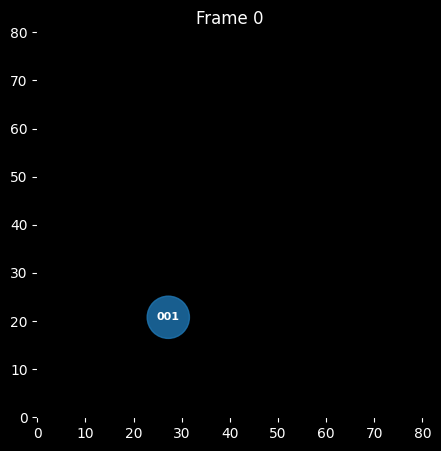

In [77]:
# Save a single frame visualization for quick reference
fig, ax = plt.subplots(figsize=(5, 5), facecolor='black')
sim.visualize_frame(frame_num=0, ax=ax, show_ids=True)
plt.savefig(os.path.join(out_dir, 'sample_frame_0000.png'), dpi=150, bbox_inches='tight', facecolor='black')

0 0
Axes(0.125,0.653529;0.227941x0.226471)
0 1
Axes(0.398529,0.653529;0.227941x0.226471)
0 2
Axes(0.672059,0.653529;0.227941x0.226471)
1 0
Axes(0.125,0.381765;0.227941x0.226471)
1 1
Axes(0.398529,0.381765;0.227941x0.226471)
1 2
Axes(0.672059,0.381765;0.227941x0.226471)
2 0
Axes(0.125,0.11;0.227941x0.226471)
2 1
Axes(0.398529,0.11;0.227941x0.226471)
2 2
Axes(0.672059,0.11;0.227941x0.226471)


/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_63018/958084025.py:373: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((x, y), radius,


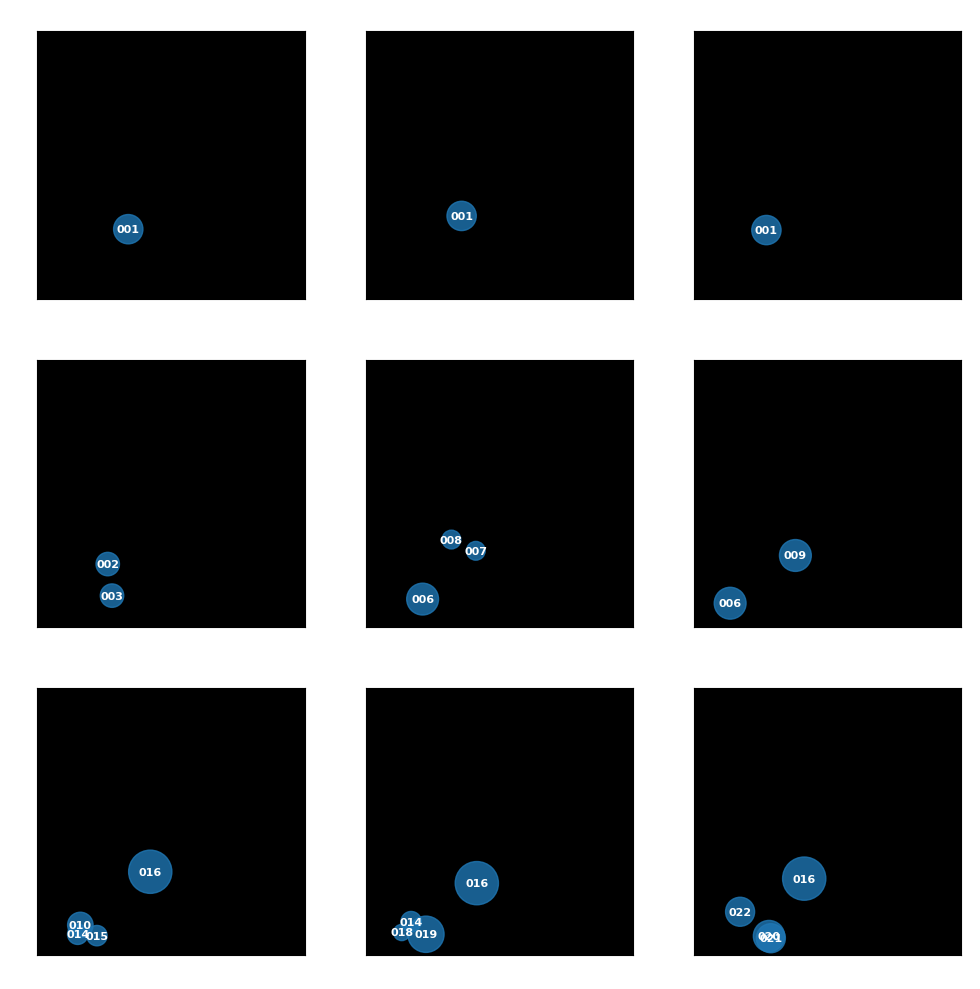

In [ ]:
# Preview: Show some sample frames
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
frames_to_show = np.linspace(0, len(sim.frames)-1, 9, dtype=int)

for i, frame_num in enumerate(frames_to_show):
    if frame_num < len(sim.frames):
        ax = axes[i//3, i%3]
        sim.visualize_frame(frame_num, ax, show_ids=True)

plt.tight_layout()
plt.show()

# Run a loop with sims for different random seeds

In [ ]:

# Create standard test datasets
core_out_dir = "../../data/1_wave_split_merge_sim/output-data"
seeds = [7, 11, 13, 17, 19, 23, 31, 37, 41, 43, 47, 42, 101, 123, 202, 303, 404, 456, 505, 789]
for seed in seeds:
    sim = SplitMergeSimulator(width=80, height=80, max_frames=150, random_seed=seed)
    sim.run_simulation(n_initial_objects=1, split_prob=0.04, merge_prob=0.04)
    out_dir = os.path.join(core_out_dir, f"sim_seed{seed:03d}/GT")
    sim.save_simulation_data(out_dir, save_csv=False, save_png=False, save_npy=True, save_json=False, save_summary_plots=True, save_viz_frames=False)
    
    # Save a single frame visualization for quick reference
    # fig, ax = plt.subplots(figsize=(5, 5), facecolor='black')
    # sim.visualize_frame(frame_num=0, ax=ax, show_ids=True)
    # plt.savefig(os.path.join(out_dir, 'sample_frame_0000.png'), dpi=150, bbox_inches='tight', facecolor='black')

Saving simulation data to: ../../data/1_split_merge_sim/output-data/sim_seed011/GT
✓ Saved 150 binary masks (numpy array)
✓ Saved 150 lineage masks with 1 lineages
✓ Created summary plots
Saving simulation data to: ../../data/1_split_merge_sim/output-data/sim_seed042/GT
✓ Saved 150 binary masks (numpy array)
✓ Saved 150 lineage masks with 1 lineages
✓ Created summary plots
Saving simulation data to: ../../data/1_split_merge_sim/output-data/sim_seed123/GT
✓ Saved 150 binary masks (numpy array)
✓ Saved 150 lineage masks with 1 lineages
✓ Created summary plots
Saving simulation data to: ../../data/1_split_merge_sim/output-data/sim_seed456/GT
✓ Saved 150 binary masks (numpy array)
✓ Saved 150 lineage masks with 1 lineages
✓ Created summary plots
Saving simulation data to: ../../data/1_split_merge_sim/output-data/sim_seed789/GT
✓ Saved 150 binary masks (numpy array)
✓ Saved 150 lineage masks with 1 lineages
✓ Created summary plots
Saving simulation data to: ../../data/1_split_merge_sim/outp

# Next step
Run `track_split_merge.ipynb` to track the events with ARCOS.px